In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from datasets.utils import generate_train_and_test_data
from datasets.segmentation.circle_segmentation import circle_segmentation_sample

In [3]:
import cv2
import numpy as np
import math

class RRect_center:
    def __init__(self, p0, s, ang):
        (self.W, self.H) = s # rectangle width and height
        self.d = math.sqrt(self.W**2 + self.H**2)/2.0 # distance from center to vertices    
        self.c = (int(p0[0]+self.W/2.0),int(p0[1]+self.H/2.0)) # center point coordinates
        self.ang = ang # rotation angle
        self.alpha = math.radians(self.ang) # rotation angle in radians
        self.beta = math.atan2(self.H, self.W) # angle between d and horizontal axis
        # Center Rotated vertices in image frame
        self.P0 = (int(self.c[0] - self.d * math.cos(self.beta - self.alpha)), int(self.c[1] - self.d * math.sin(self.beta-self.alpha))) 
        self.P1 = (int(self.c[0] - self.d * math.cos(self.beta + self.alpha)), int(self.c[1] + self.d * math.sin(self.beta+self.alpha))) 
        self.P2 = (int(self.c[0] + self.d * math.cos(self.beta - self.alpha)), int(self.c[1] + self.d * math.sin(self.beta-self.alpha))) 
        self.P3 = (int(self.c[0] + self.d * math.cos(self.beta + self.alpha)), int(self.c[1] - self.d * math.sin(self.beta+self.alpha))) 

        self.verts = [self.P0,self.P1,self.P2,self.P3]

    def draw(self, image):
        rect = cv2.minAreaRect(np.asarray(self.verts))
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(image,[box],0,0,-1)
        cv2.drawContours(image,[box],0,255,2)
        
    def fill_value(self, image, value):
        rect = cv2.minAreaRect(np.asarray(self.verts))
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(image,[box],0,value,-1)

def sticks_instance_segmentation_sample(width, height, max_sticks=5):

    img = np.zeros((height, width)).astype(np.uint8)
    mask = np.zeros((height, width, 1)).astype(np.uint8)
    n_sticks = np.random.randint(2, max_sticks)
    for i in range(1, n_sticks+1):
        
        top_left = (np.random.randint(20, width-20), np.random.randint(20, height-20)) 
        angles = np.random.randint(0, 360)
        
        rect = RRect_center(top_left, (10, 50), angles)
        while not all([(0 < x[0] < width) and (0 < x[1] < height) for x in rect.verts]):
            top_left = (np.random.randint(20, width-20), np.random.randint(20, height-20)) 
            rect = RRect_center(top_left, (10, 50), angles)
        
        rect.draw(img)
        rect.fill_value(mask, i)
        
        
    return np.expand_dims(img, -1), mask

In [4]:
(X_train, Y_train), (X_test, Y_test) = \
    generate_train_and_test_data(sticks_instance_segmentation_sample, width=128, height=128, n_samples_train=30000)

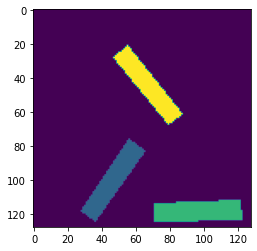

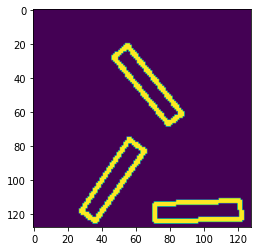

In [5]:
plt.imshow(Y_train[0][...,0])
plt.show()
plt.imshow(X_train[0][...,0])
plt.show()

In [6]:
X_train = X_train / 255
X_test = X_test / 255

In [119]:
input = keras.layers.Input((128, 128, 1))

conv1 = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input) 
maxp1 = keras.layers.MaxPool2D((2,2))(conv1)                                    

conv2 = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(maxp1) 
maxp2 = keras.layers.MaxPool2D((2,2))(conv2)                                     
 
conv3 = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(maxp2)
maxp3 = keras.layers.MaxPool2D((2,2))(conv3)  

conv4 = keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(maxp3)
maxp4 = keras.layers.MaxPool2D((2,2))(conv4)


tconv5 = keras.layers.Conv2DTranspose(256, (3,3), strides=(2,2),                       
                                      padding="same", activation="relu")(maxp4) 
con5 = keras.layers.concatenate([tconv5, conv4], axis=3)

tconv6 = keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2),                       
                                      padding="same", activation="relu")(con5)  
con6 = keras.layers.concatenate([tconv6, conv3], axis=3)  

tconv7 = keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2),                       
                                      padding="same", activation="relu")(con6)  
con7 = keras.layers.concatenate([tconv7, conv2], axis=3)                      

tconv8 = keras.layers.Conv2DTranspose(32, (3,3), strides=(2,2),                       
                                      padding="same", activation="relu")(con7)  
con8 = keras.layers.concatenate([tconv8, conv1], axis=3)                      

conv9 = keras.layers.Conv2D(3, (1,1), padding="same", activation="linear", use_bias=False)(con8)

model = keras.models.Model(input, conv9)

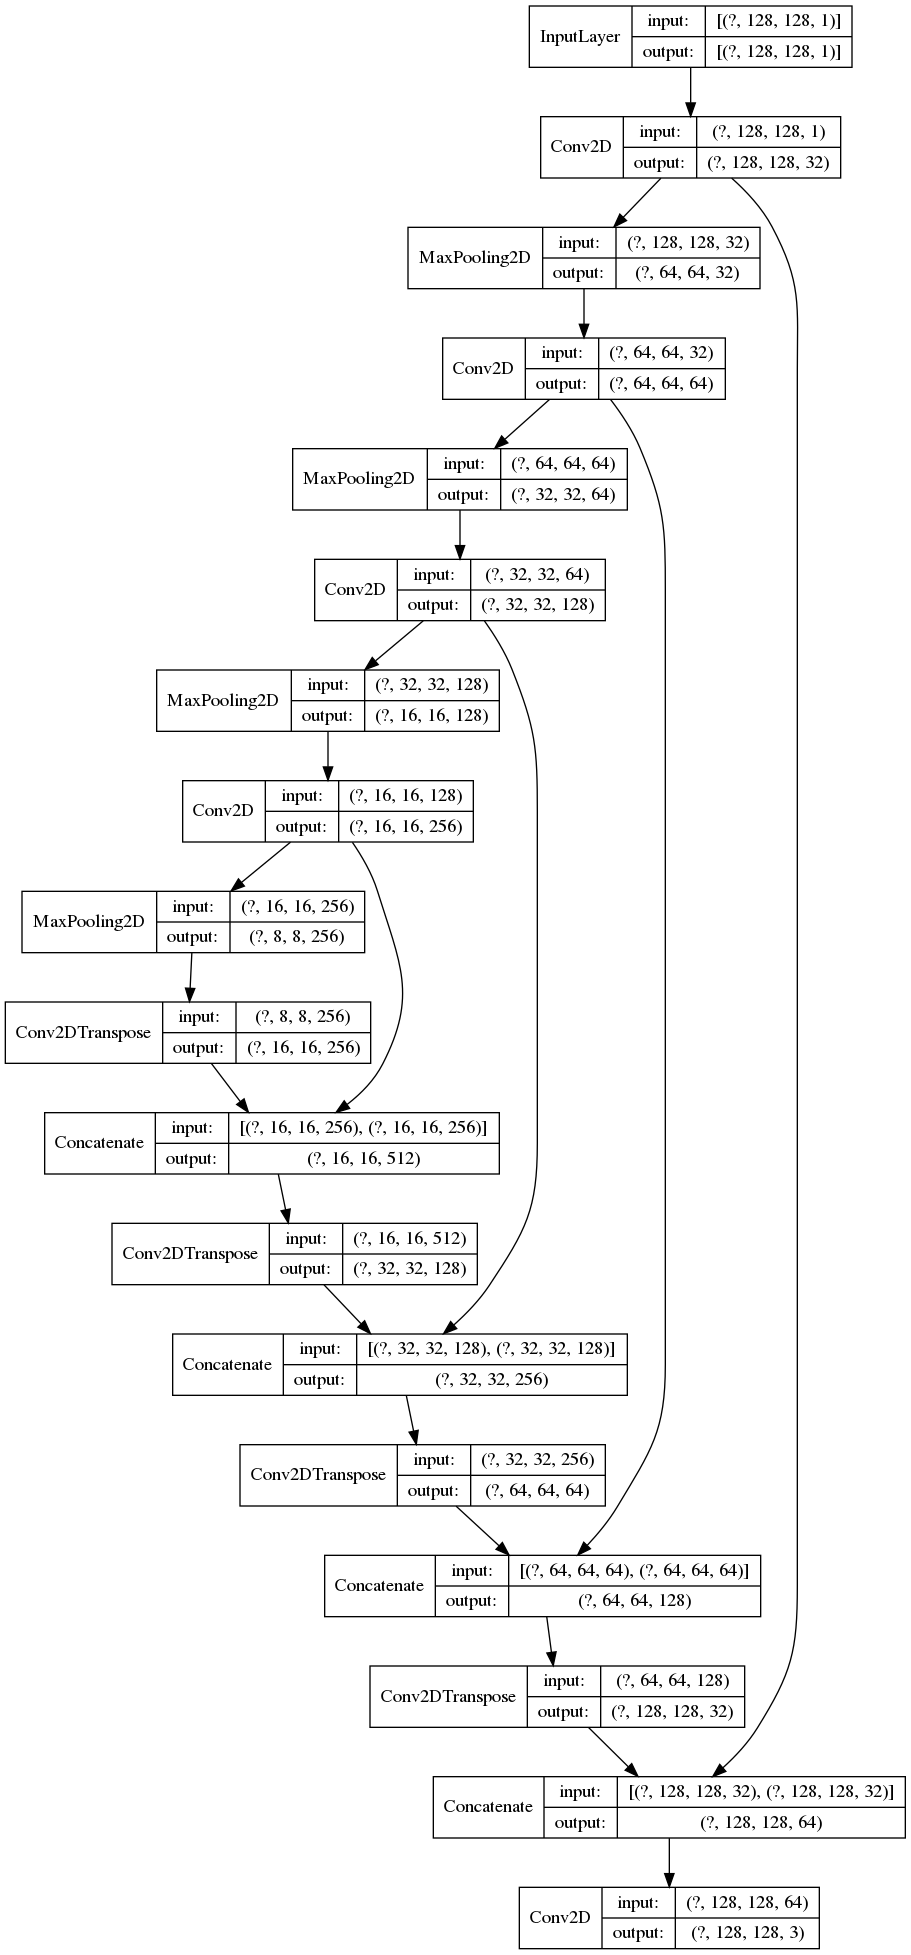

In [120]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

In [1]:
def discriminative_loss_single(
        prediction,
        correct_label,
        feature_dim,
        label_shape,
        delta_v,
        delta_d,
        param_var,
        param_dist,
        param_reg):
    """
    discriminative loss
    :param prediction: inference of network
    :param correct_label: instance label
    :param feature_dim: feature dimension of prediction
    :param label_shape: shape of label
    :param delta_v: cut off variance distance
    :param delta_d: cut off cluster distance
    :param param_var: weight for intra cluster variance
    :param param_dist: weight for inter cluster distances
    :param param_reg: weight regularization
    """
    correct_label = tf.reshape(
        correct_label, [label_shape[1] * label_shape[0]]
    )
    reshaped_pred = tf.reshape(
        prediction, [label_shape[1] * label_shape[0], feature_dim]
    )
    
    # calculate instance nums
    unique_labels, unique_id, counts = tf.unique_with_counts(correct_label)
    counts = tf.cast(counts, tf.float32)
    num_instances = tf.size(unique_labels)

    # calculate instance pixel embedding mean vec
    segmented_sum = tf.unsorted_segment_sum(
        reshaped_pred, unique_id, num_instances)
    mu = tf.div(segmented_sum, tf.reshape(counts, (-1, 1)))
    mu_expand = tf.gather(mu, unique_id)

    distance = tf.norm(tf.subtract(mu_expand, reshaped_pred), axis=1, ord=1)
    distance = tf.subtract(distance, delta_v)
    distance = tf.clip_by_value(distance, 0., distance)
    distance = tf.square(distance)

    l_var = tf.unsorted_segment_sum(distance, unique_id, num_instances)
    l_var = tf.div(l_var, counts)
    l_var = tf.reduce_sum(l_var)
    l_var = tf.divide(l_var, tf.cast(num_instances, tf.float32))

    mu_interleaved_rep = tf.tile(mu, [num_instances, 1])
    mu_band_rep = tf.tile(mu, [1, num_instances])
    mu_band_rep = tf.reshape(
        mu_band_rep,
        (num_instances *
         num_instances,
         feature_dim))

    mu_diff = tf.subtract(mu_band_rep, mu_interleaved_rep)

    intermediate_tensor = tf.reduce_sum(tf.abs(mu_diff), axis=1)
    zero_vector = tf.zeros(1, dtype=tf.float32)
    bool_mask = tf.not_equal(intermediate_tensor, zero_vector)
    mu_diff_bool = tf.boolean_mask(mu_diff, bool_mask)

    mu_norm = tf.norm(mu_diff_bool, axis=1, ord=1)
    mu_norm = tf.subtract(2. * delta_d, mu_norm)
    mu_norm = tf.clip_by_value(mu_norm, 0., mu_norm)
    mu_norm = tf.square(mu_norm)

    l_dist = tf.reduce_mean(mu_norm)

    l_reg = tf.reduce_mean(tf.norm(mu, axis=1, ord=1))

    param_scale = 1.
    l_var = param_var * l_var
    l_dist = param_dist * l_dist
    l_reg = param_reg * l_reg

    loss = param_scale * (l_var + l_dist + l_reg)

    return loss, l_var, l_dist, l_reg


def discriminative_loss(correct_label, prediction, feature_dim=3, image_shape=(128,128), 
                delta_v=0.5, delta_d=1.5, param_var=1, param_dist=1, param_reg=0.001):
    ''' Iterate over a batch of prediction/label and cumulate loss
    :return: discriminative loss and its three components
    '''
    def cond(label, batch, out_loss, out_var, out_dist, out_reg, i):
        return tf.less(i, tf.shape(batch)[0])

    def body(label, batch, out_loss, out_var, out_dist, out_reg, i):
        disc_loss, l_var, l_dist, l_reg = discriminative_loss_single(prediction[i], correct_label[i], feature_dim, image_shape, 
                        delta_v, delta_d, param_var, param_dist, param_reg)

        out_loss = out_loss.write(i, disc_loss)
        out_var = out_var.write(i, l_var)
        out_dist = out_dist.write(i, l_dist)
        out_reg = out_reg.write(i, l_reg)

        return label, batch, out_loss, out_var, out_dist, out_reg, i + 1

    # TensorArray is a data structure that support dynamic writing
    output_ta_loss = tf.TensorArray(dtype=tf.float32,
                   size=0,
                   dynamic_size=True)
    output_ta_var = tf.TensorArray(dtype=tf.float32,
                   size=0,
                   dynamic_size=True)
    output_ta_dist = tf.TensorArray(dtype=tf.float32,
                   size=0,
                   dynamic_size=True)
    output_ta_reg = tf.TensorArray(dtype=tf.float32,
                   size=0,
                   dynamic_size=True)

    _, _, out_loss_op, _, _, _, _  = tf.while_loop(cond, body, [correct_label, 
                                                        prediction, 
                                                        output_ta_loss, 
                                                        output_ta_var, 
                                                        output_ta_dist, 
                                                        output_ta_reg, 
                                                        0])
    out_loss_op = out_loss_op.stack()
    disc_loss = tf.reduce_mean(out_loss_op)

    return disc_loss

In [124]:
import keras.backend as K


model.compile("adam", loss=discriminative_loss)
model.fit(X_train, Y_train, epochs=100, batch_size=32)

/home/dlopez/analytics-antenna-detection/artifacts/venv/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30000 samples
Epoch 1/100
 6848/30000 [=====>........................] - ETA: 12:47 - loss: 2.8050

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


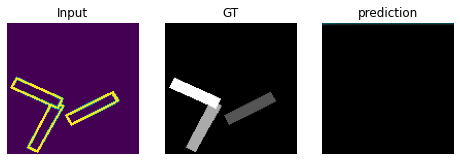

In [126]:
import matplotlib.pyplot as plt
idx = np.random.randint(X_test.shape[0])


plt.figure(figsize=(8,8))
ax = plt.subplot(131)
ax.imshow(X_train[idx,:,:,0])
ax.axis("off")
ax.set_title("Input")
ax = plt.subplot(132)
ax.imshow(Y_train[idx,:,:,0], cmap="gray")
ax.axis("off")
ax.set_title("GT")
ax = plt.subplot(133)
pred = model.predict(X_train[idx:idx+1])[0,:,:]
#pred = pred - np.min(pred)
pred = pred / np.max(pred)
ax.imshow(pred)
ax.set_title("prediction")
ax.axis("off")
plt.show()

In [197]:
from sklearn.neighbors import NearestNeighbors

def embeddings_to_instances(embeddings_map, segmentation,
                            embedding_distance_threshold = 0.5, segmentation_threshold = 0.5,
                            center_change_tol = 0.001, min_samples_per_instance = 20):
    
    embedding_dim = embeddings_map.shape[-1]
    relevant_embedding_selection_mask = (segmentation > segmentation_threshold).ravel()
    embeddings = embeddings_map.reshape((-1, embedding_dim))[relevant_embedding_selection_mask]
    
    nn = NearestNeighbors().fit(embeddings)
    
    labels = np.full(len(embeddings), -1, dtype=np.int32)
    
    instance_id = 0
    while np.any(labels == -1):
        
        unclustered_idxs = np.where(labels == -1)[0]
        seed_idx = unclustered_idxs[np.random.randint(len(unclustered_idxs))]
        
        center = embeddings[seed_idx]
        
        center_change = np.inf
        while center_change > center_change_tol:
            in_radius_idxs = nn.radius_neighbors(
                [center], return_distance=False, radius=embedding_distance_threshold)[0]
            new_center = np.mean(embeddings[in_radius_idxs], axis=0) if len(in_radius_idxs) > 0 else center
            
            center_change = np.linalg.norm(center - new_center)
            center = new_center

        labels[in_radius_idxs] = instance_id
        labels[seed_idx] = instance_id
        instance_id += 1
        
        points_left = np.sum(labels==-1)
        
    
    values, counts = np.unique(labels, return_counts=True)
    for (label, count) in zip(values, counts):
        if count < min_samples_per_instance:            
            labels[labels == label] = -1
        
    new_label = 0
    for label in np.unique(labels):
        if label != -1:
            labels[labels == label] = new_label
            new_label += 1
        
    full_image_labels = np.full(np.prod(embeddings_map.shape[:2]), -1, dtype=np.int32)
    full_image_labels[relevant_embedding_selection_mask] = labels
    
    return full_image_labels.reshape(embeddings_map.shape[:2])
    


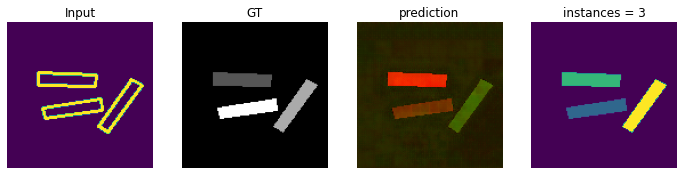

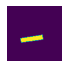

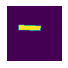

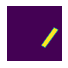

In [219]:
idx = np.random.randint(X_test.shape[0])
plt.figure(figsize=(12,8))
ax = plt.subplot(141)
ax.imshow(X_train[idx,:,:,0])
ax.axis("off")
ax.set_title("Input")
ax = plt.subplot(142)
segmentation = Y_train[idx,:,:,0] > 0
ax.imshow(Y_train[idx,:,:,0], cmap="gray")
ax.axis("off")
ax.set_title("GT")
ax = plt.subplot(143)
pred = model.predict(X_train[idx:idx+1])[0,:,:]
pred_scaled = pred / np.max(pred)
ax.imshow(pred_scaled)
ax.set_title("prediction")
ax.axis("off")

discretized_emb = embeddings_to_instances(pred, segmentation>0, embedding_distance_threshold=1.25)

ax = plt.subplot(144)
ax.imshow(discretized_emb)
ax.set_title(f"instances = {len(np.unique(discretized_emb))-1}")
ax.axis("off")
plt.show()

for label in np.unique(discretized_emb):
    
    if label != -1:
        plt.figure(figsize=(1,1))
        plt.imshow(discretized_emb == label)
        plt.axis("off")
        plt.show()